In [1]:
% matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = tables.table_id.str.contains('acs') & tables.row_count.between(190000, 220000)
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
23,acs_blockgroup_2015,216362
24,acs_blockgroup_2016,216362
57,acs_blockgroup_2017,214521
20,acs_education,212249
21,acs_school_enrollment,212249
19,acs_hispanic,212247
49,acs_employment,207265
47,acs_race,207262
48,acs_total_population,207262
43,acs_sex_by_age,203137


# census_block, left join fcc and acs attributes

In [3]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group,
    block.total_length, 
    block.land_area, 
    block.elevation_mean,
    block.elevation_range,
    CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.population_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group,
    AVG(int_avail) AS int_avail_per,
    SUM(total_length) AS total_length, 
    SUM(land_area) AS total_land_area, 
    AVG(elevation_mean) AS avg_elevation,
    AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT 
  block_group_level.*,
  acs_total_population.estimate_total AS population,
  acs_housing_unit.estimate_total AS housing_units,
  acs_median_income.estimate_median_household_income_in_the_past_12_months_in_2016_inflation_adjusted_dollars AS income,
  acs_education_average.avg_years_of_edu,
  acs_employment_percentage.unemployment_rate,
  acs_gender_age.male_ratio,
  acs_gender_age.avg_age,
  SAFE_DIVIDE(acs_race.estimate_total__white_alone, acs_race.estimate_total) AS white_ratio,
  SAFE_DIVIDE(acs_race.estimate_total__black_or_african_american_alone, acs_race.estimate_total) AS black_ratio,
  SAFE_DIVIDE(acs_race.estimate_total__asian_alone, acs_race.estimate_total) AS asian_ratio,
  SAFE_DIVIDE(acs_hispanic.estimate_total__hispanic_or_latino, acs_hispanic.estimate_total) AS hispanic_ratio
FROM block_group_level
LEFT JOIN broadband.acs_total_population
  ON block_group_level.block_group = acs_total_population.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_median_income
  ON block_group_level.block_group = acs_median_income.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.acs_race
  ON block_group_level.block_group = acs_race.block_group_code
LEFT JOIN broadband.acs_hispanic
  ON block_group_level.block_group = acs_hispanic.block_group_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [4]:
data.shape

(1106079, 17)

### Missing values

In [5]:
data.count() / data.shape[0] * 100

block_group           100.000000
int_avail_per         100.000000
total_length          100.000000
total_land_area       100.000000
avg_elevation         100.000000
avg_elevation_range   100.000000
population             98.858129
housing_units          98.444867
income                 97.096410
avg_years_of_edu       99.131708
unemployment_rate      98.618272
male_ratio             98.337189
avg_age                98.337189
white_ratio            98.708682
black_ratio            98.708682
asian_ratio            98.708682
hispanic_ratio         99.157655
dtype: float64

Text(0.5,0,'Internet availability percentage')

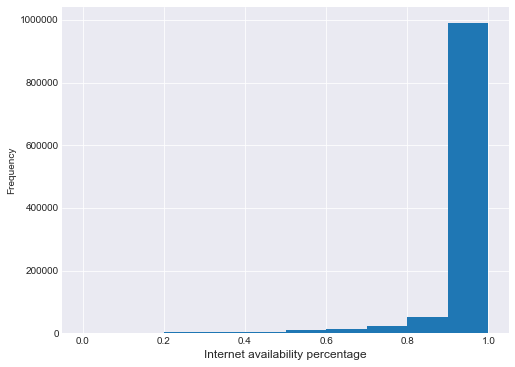

In [6]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [7]:
data.int_avail_per.describe()

count   1,106,079.000000
mean            0.965304
std             0.108983
min             0.000000
25%             1.000000
50%             1.000000
75%             1.000000
max             1.000000
Name: int_avail_per, dtype: float64

In [8]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', 100 - full_coverage)
print('block_group without full coverage', full_coverage)

block_group with full coverage 19.002530560656155
block_group without full coverage 80.99746943934385
